# Plot power curves for turbine 2 with data filters

In [ ]:
"""Plot power curves for turbine 2 with data filters

"""

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [ ]:
# import data
df = pd.read_csv('data/SCADA_downtime_merged.csv', skip_blank_lines=True)

In [ ]:
# list of turbines to plot (just 2)
list1 = [2]
# list of categories to plot
list2 = list(df['TurbineCategory_id'].unique())
# remove NaN from list
list2 = [g for g in list2 if g >= 0]
# round from float to integer
list2 = [a.astype(np.int64) for a in list2]
# sort categories in ascending order
list2 = sorted(list2, key=int)
# categories to remove from plot
list2 = [b for b in list2 if b not in (1, 12, 13, 14, 15, 17, 21, 22)]
list3 = list(itertools.product(list1, list2))

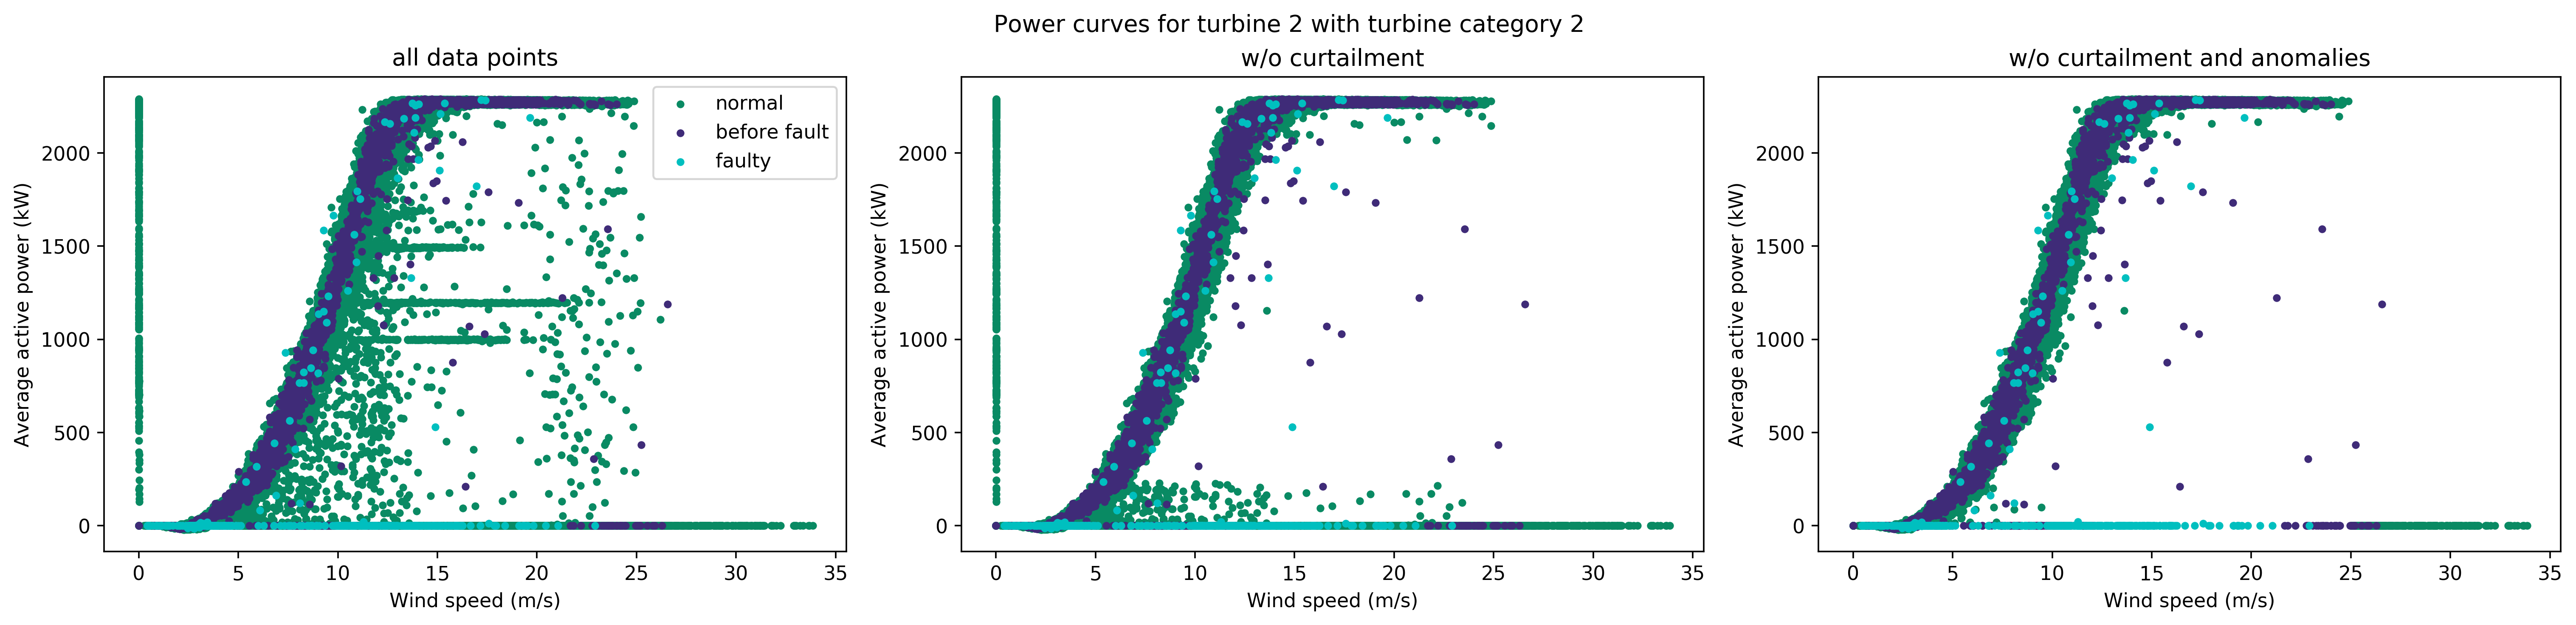

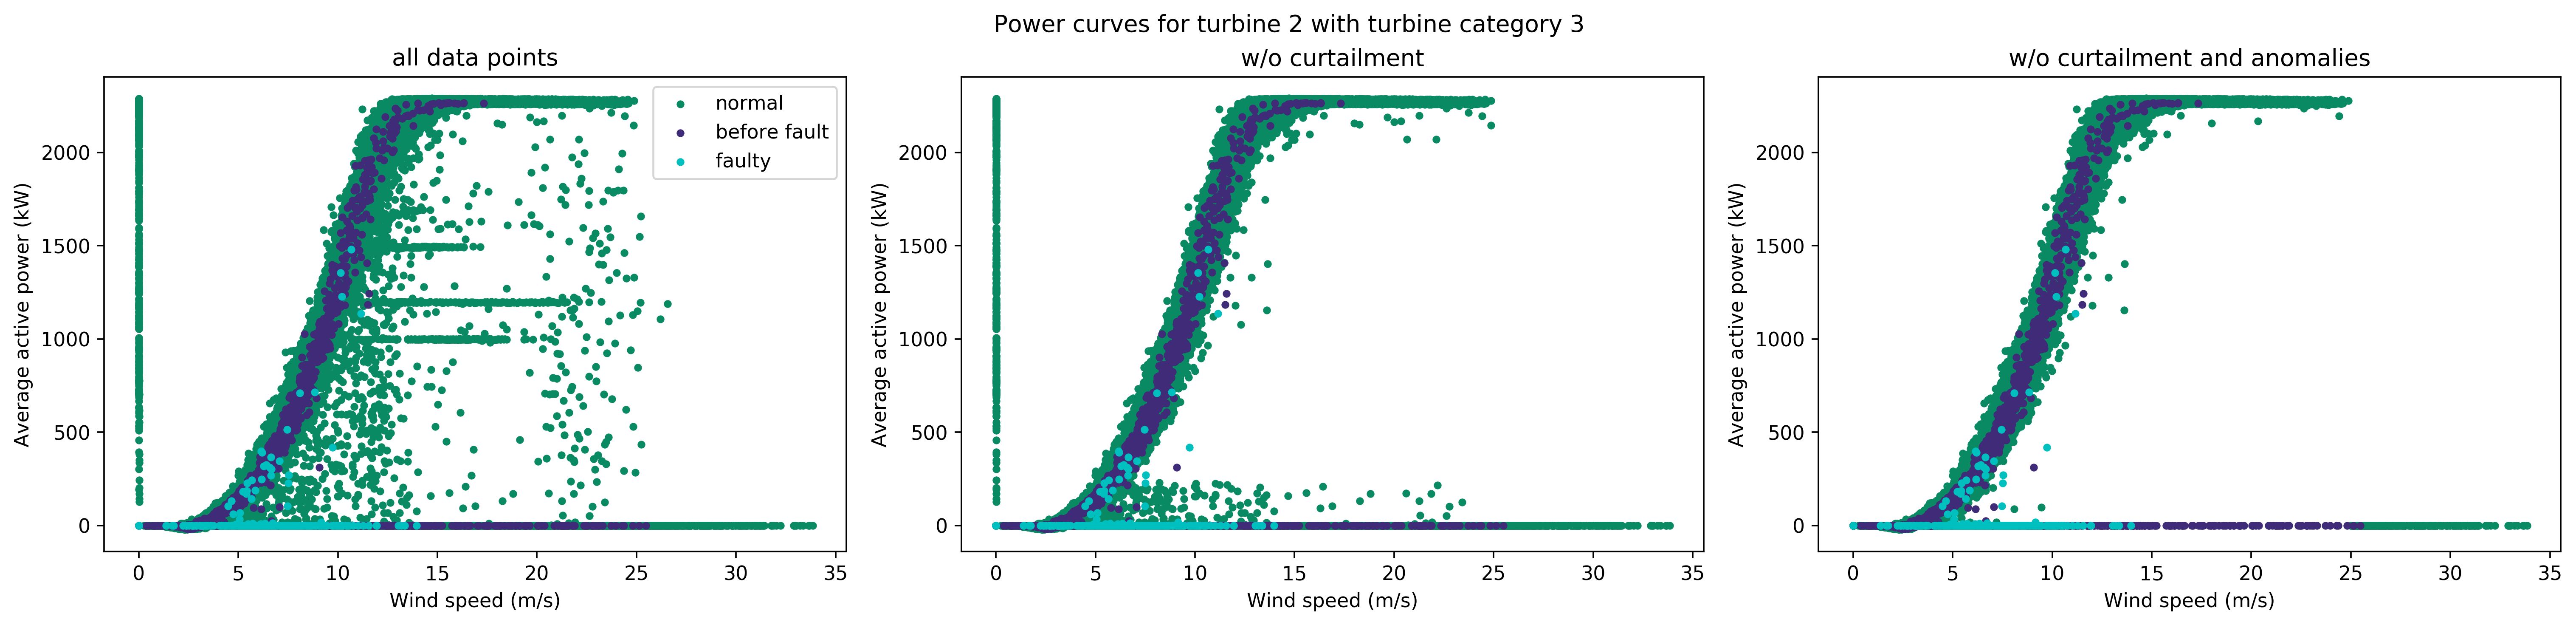

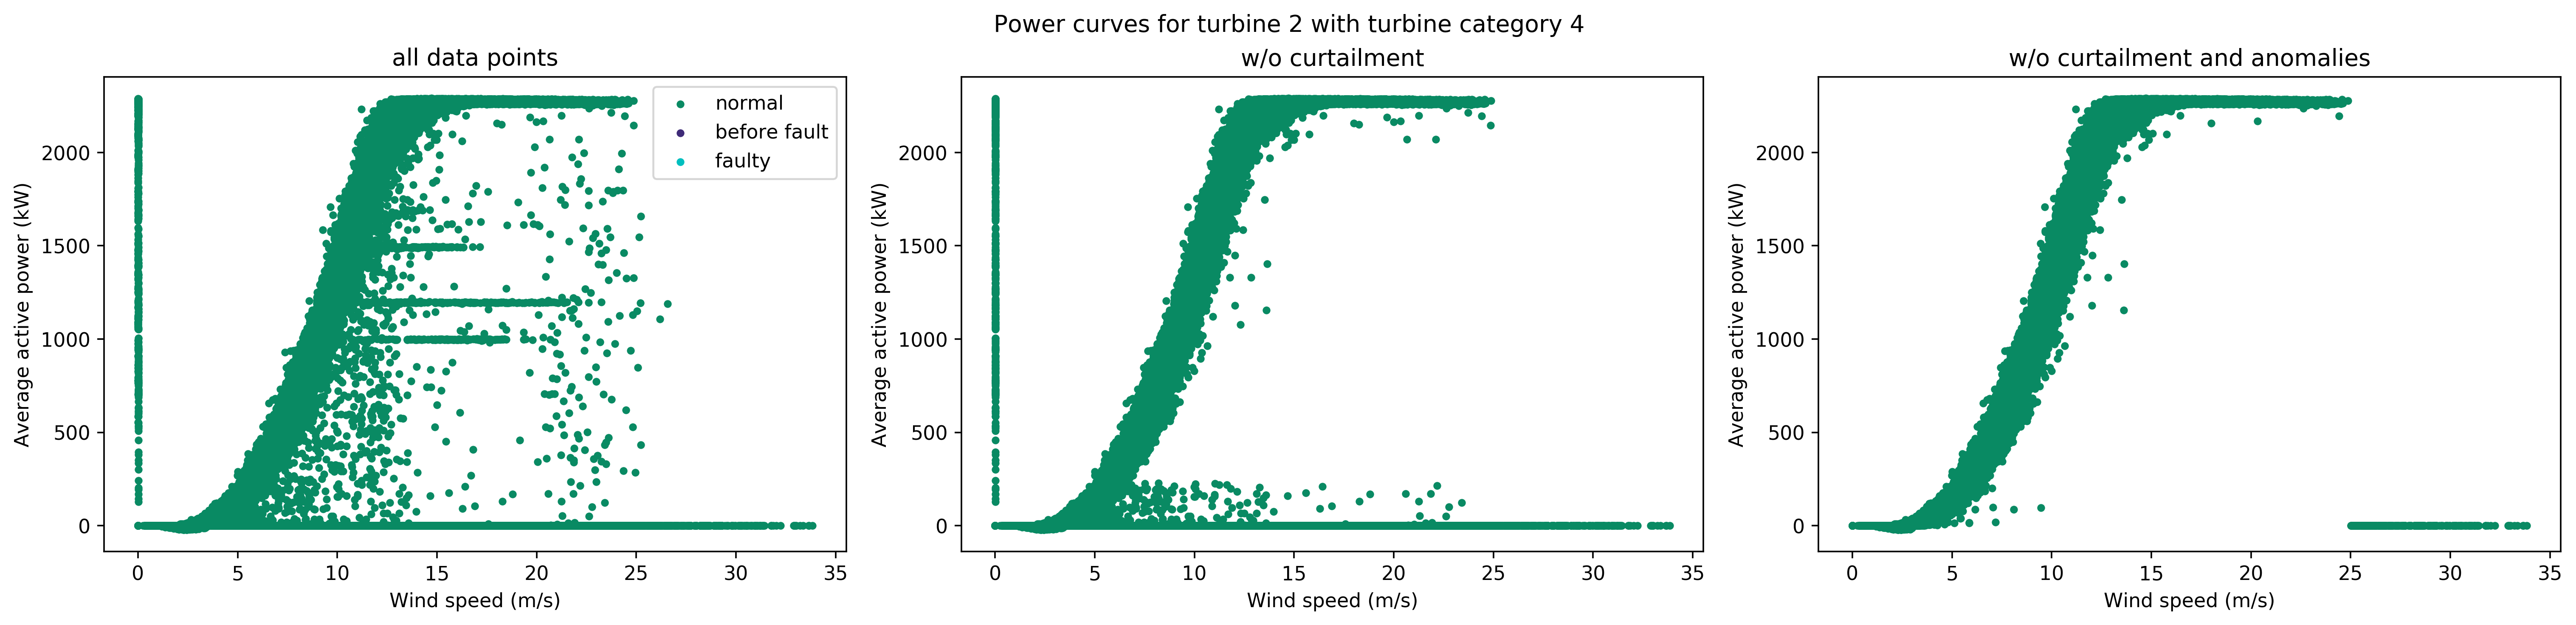

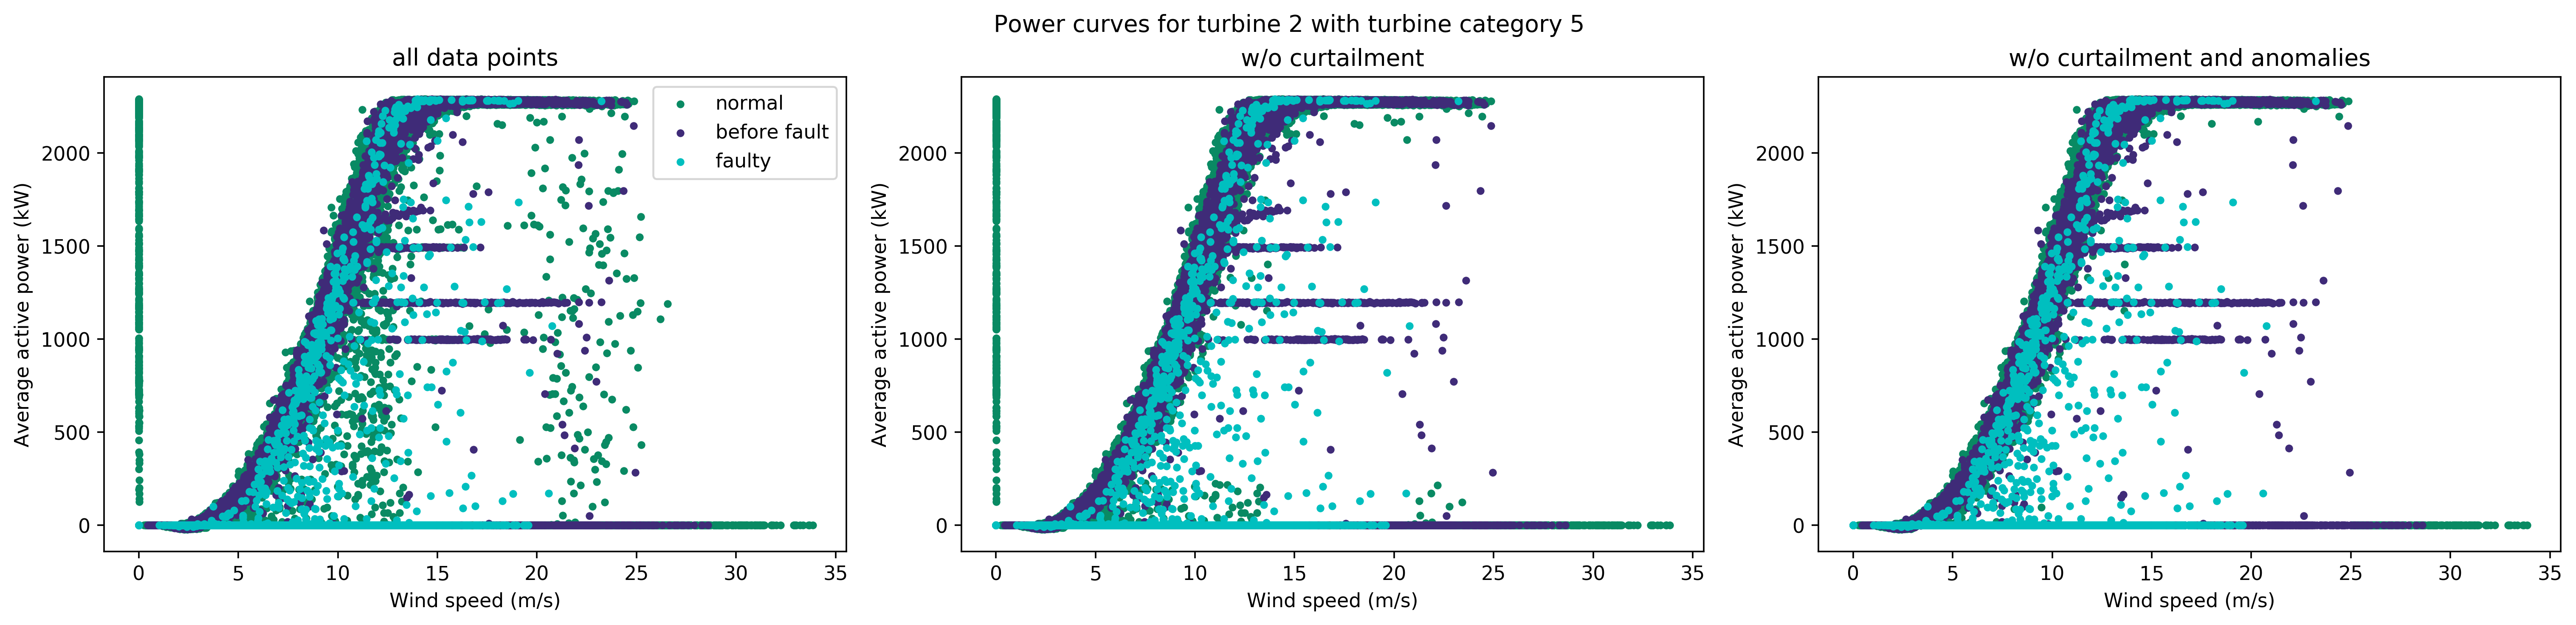

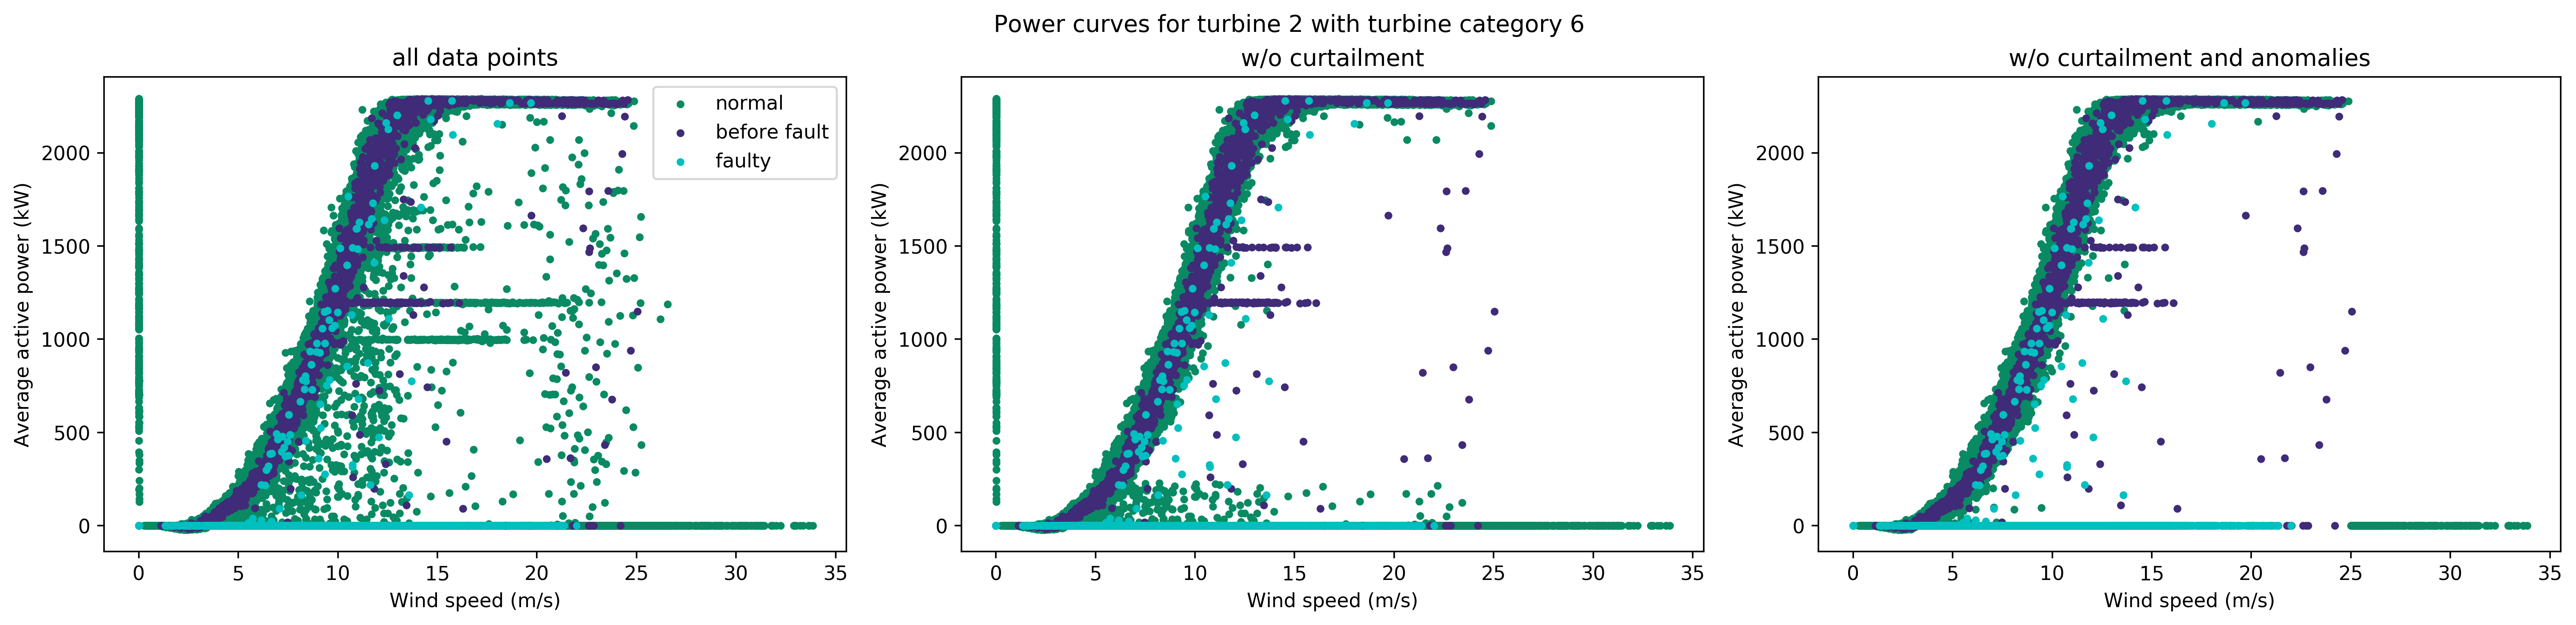

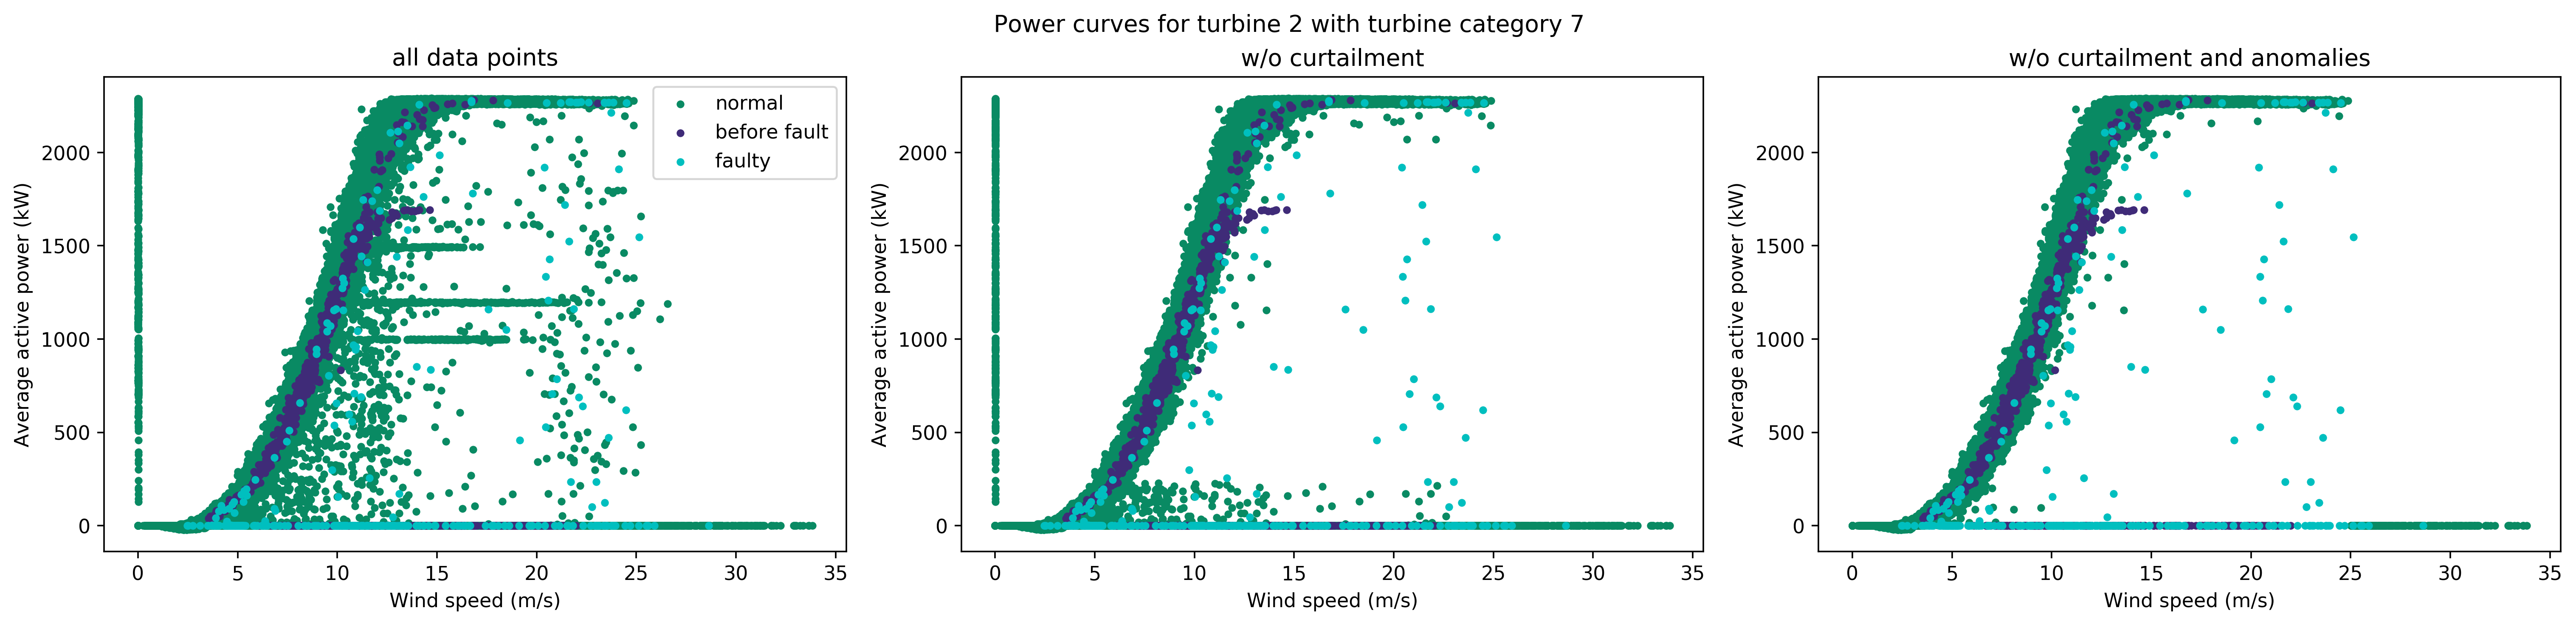

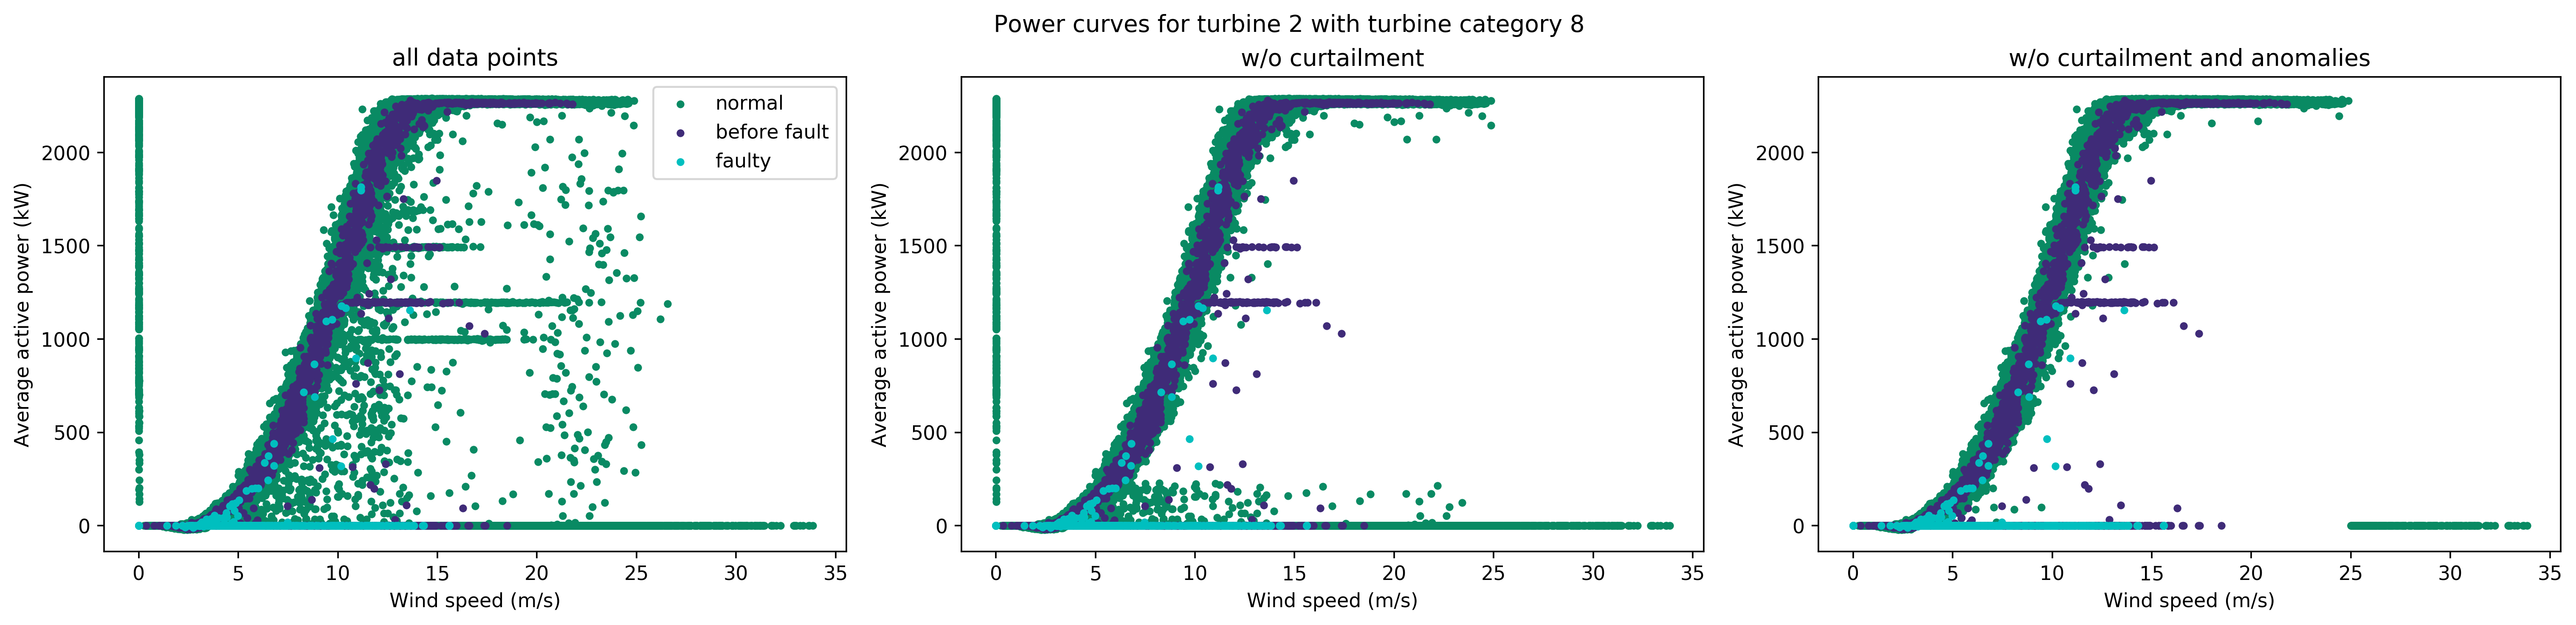

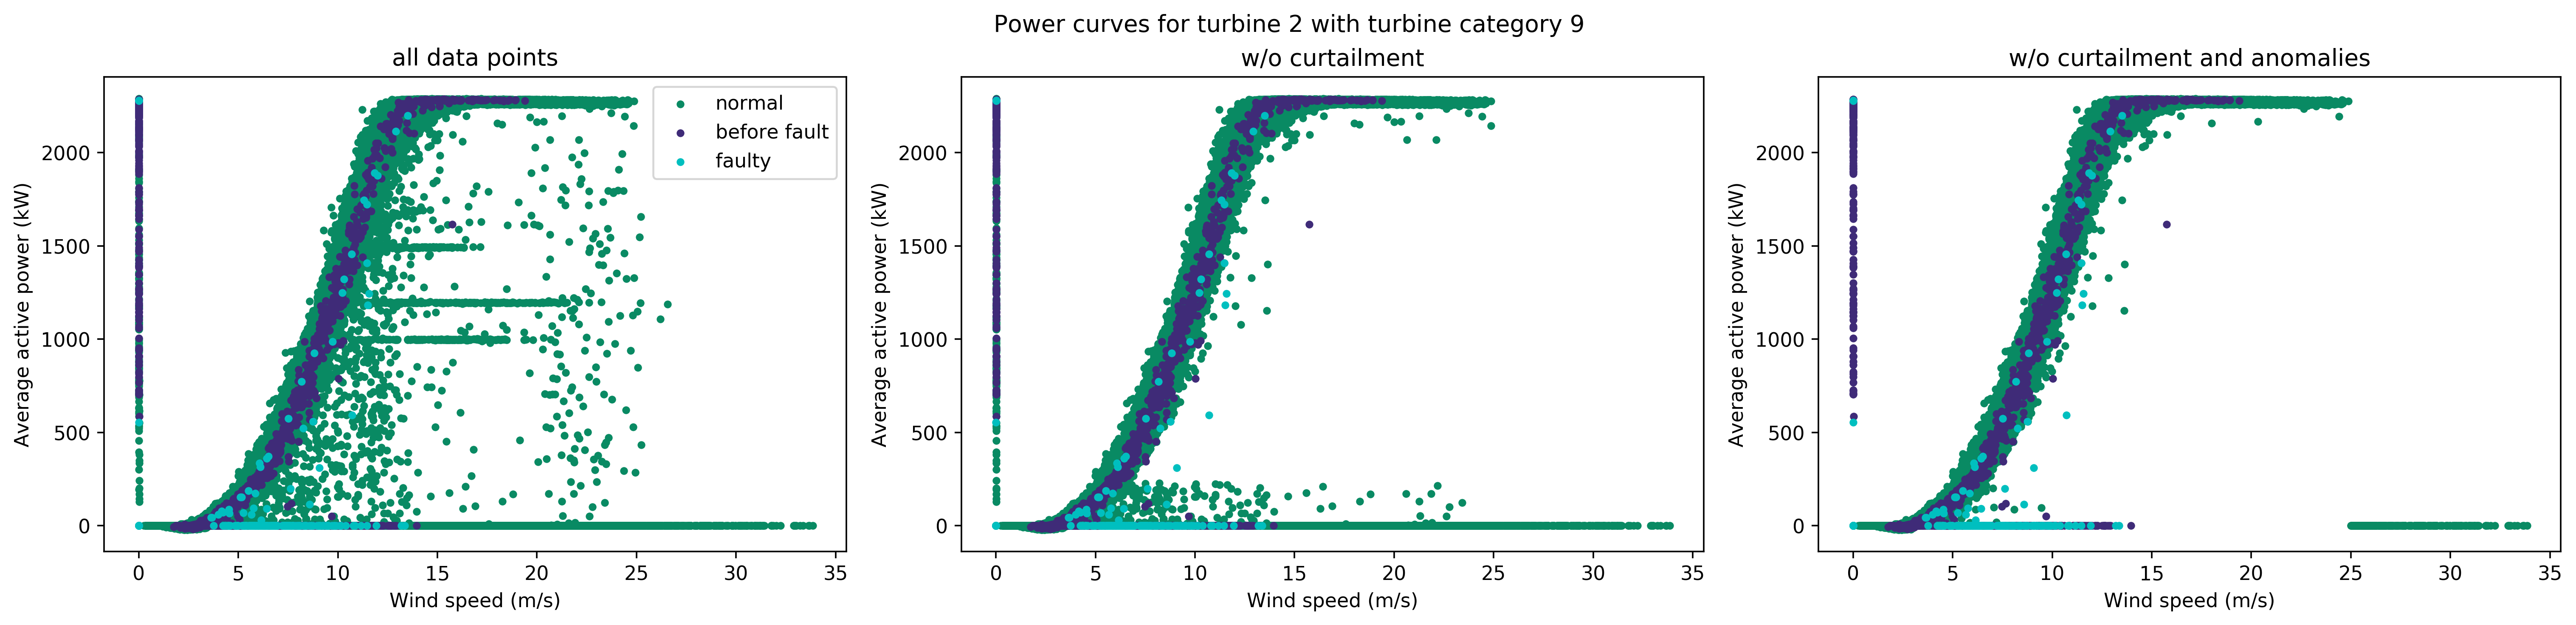

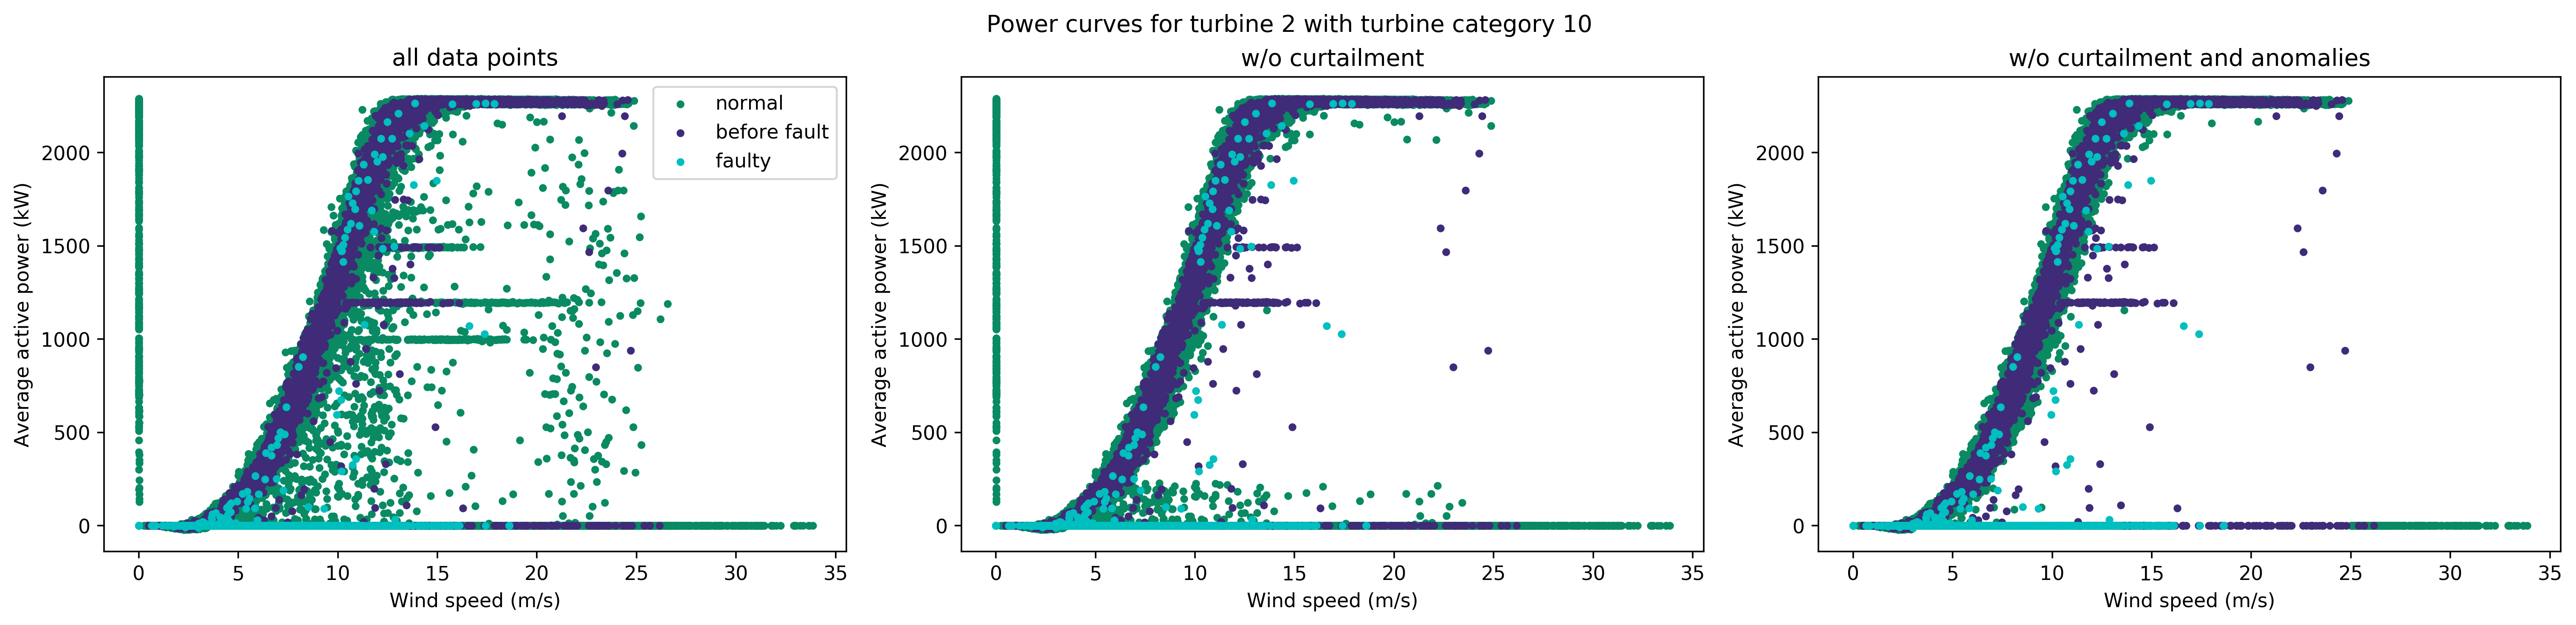

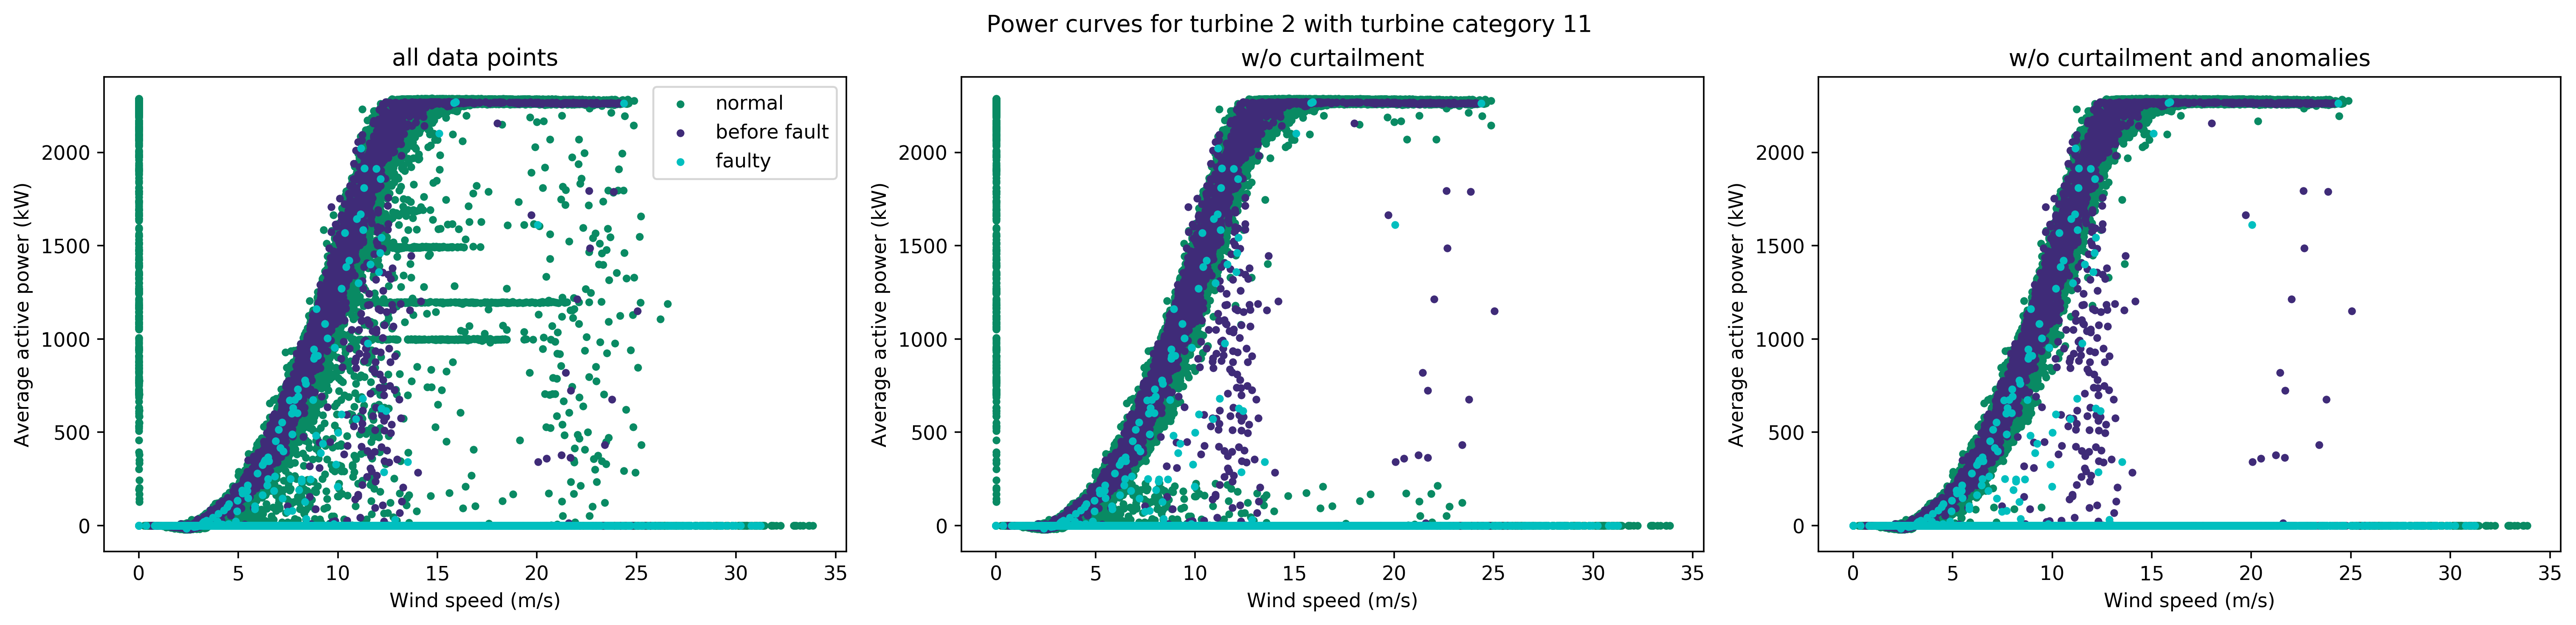

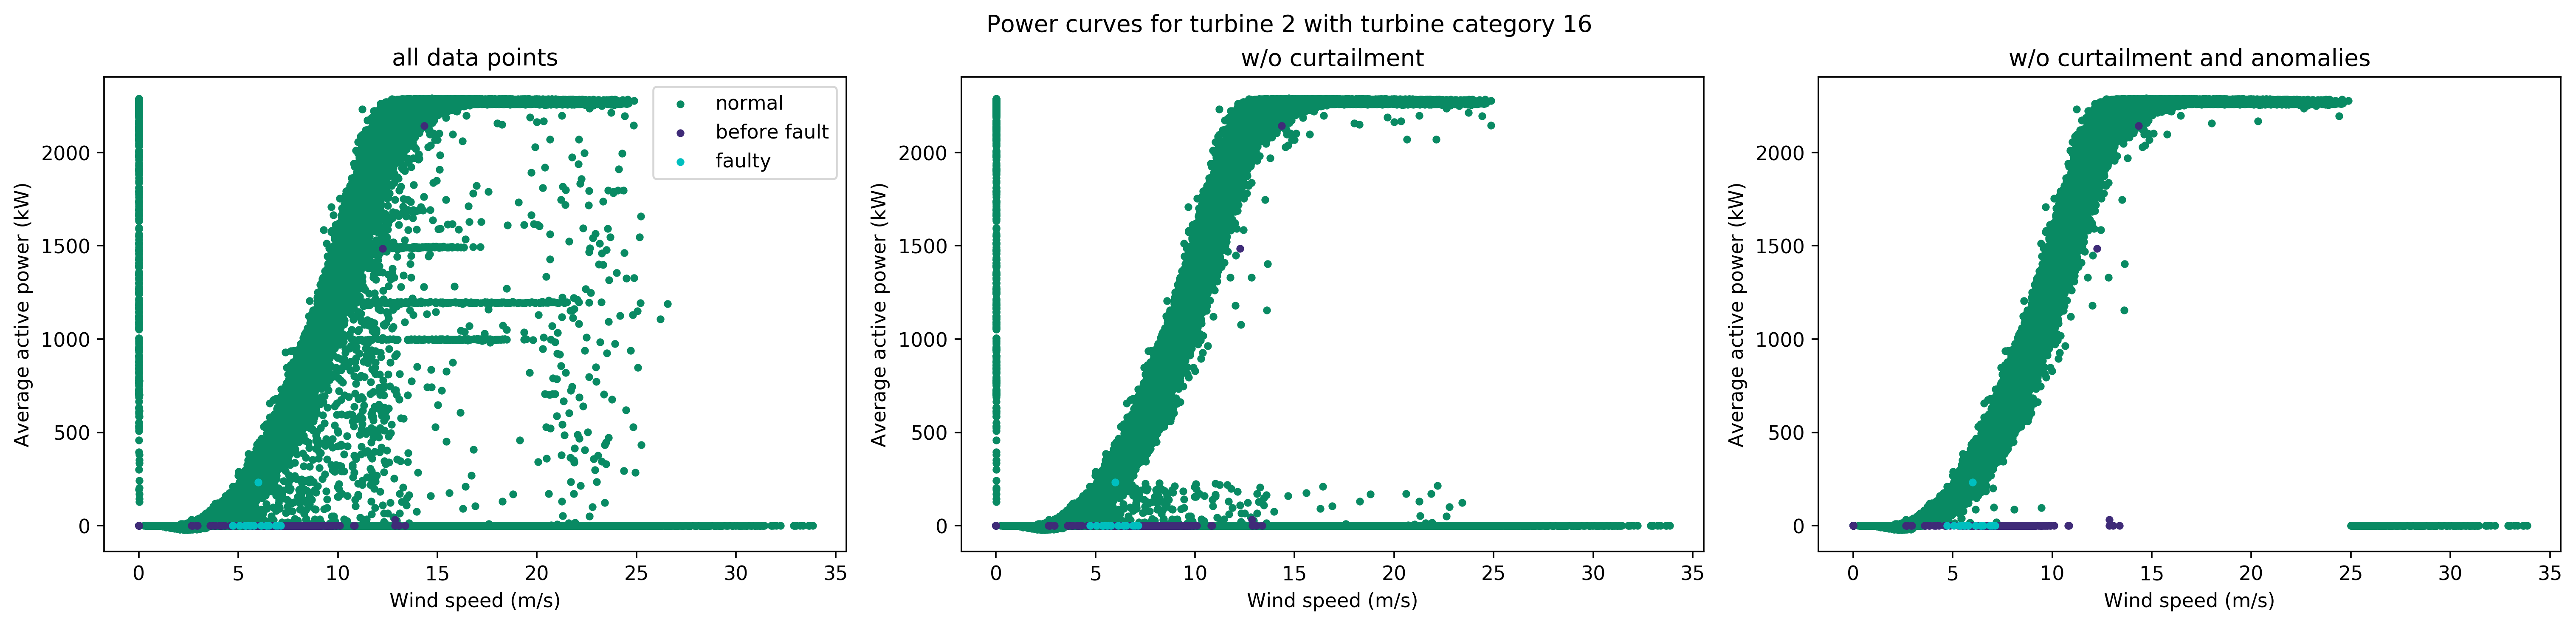

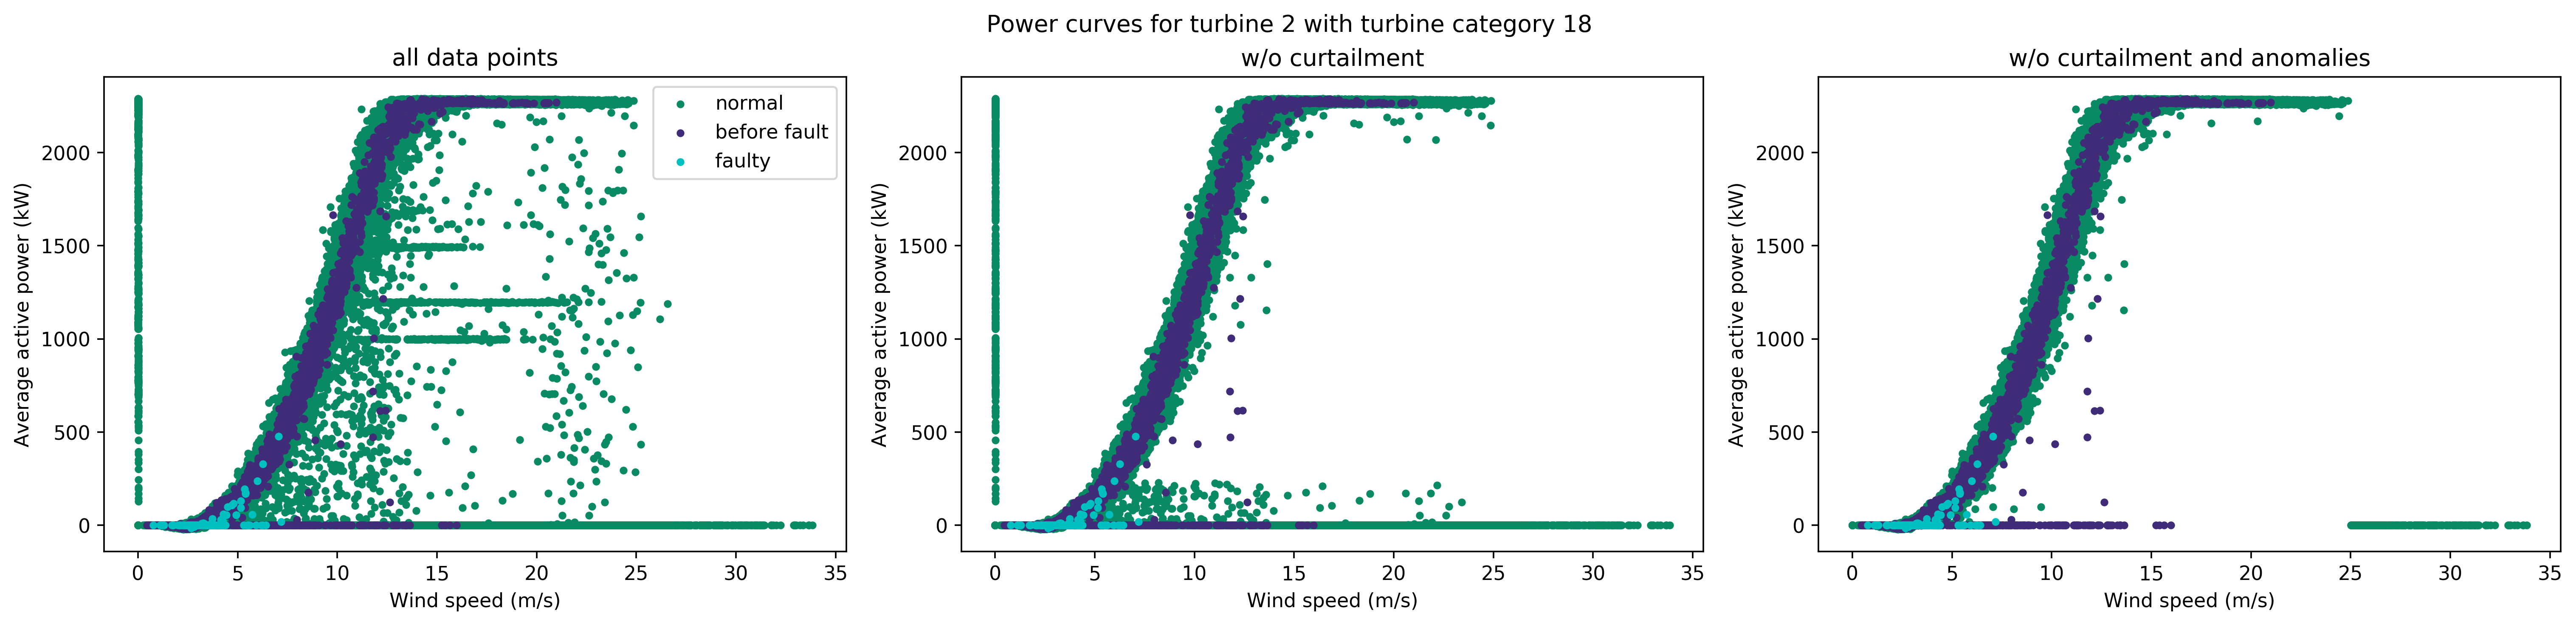

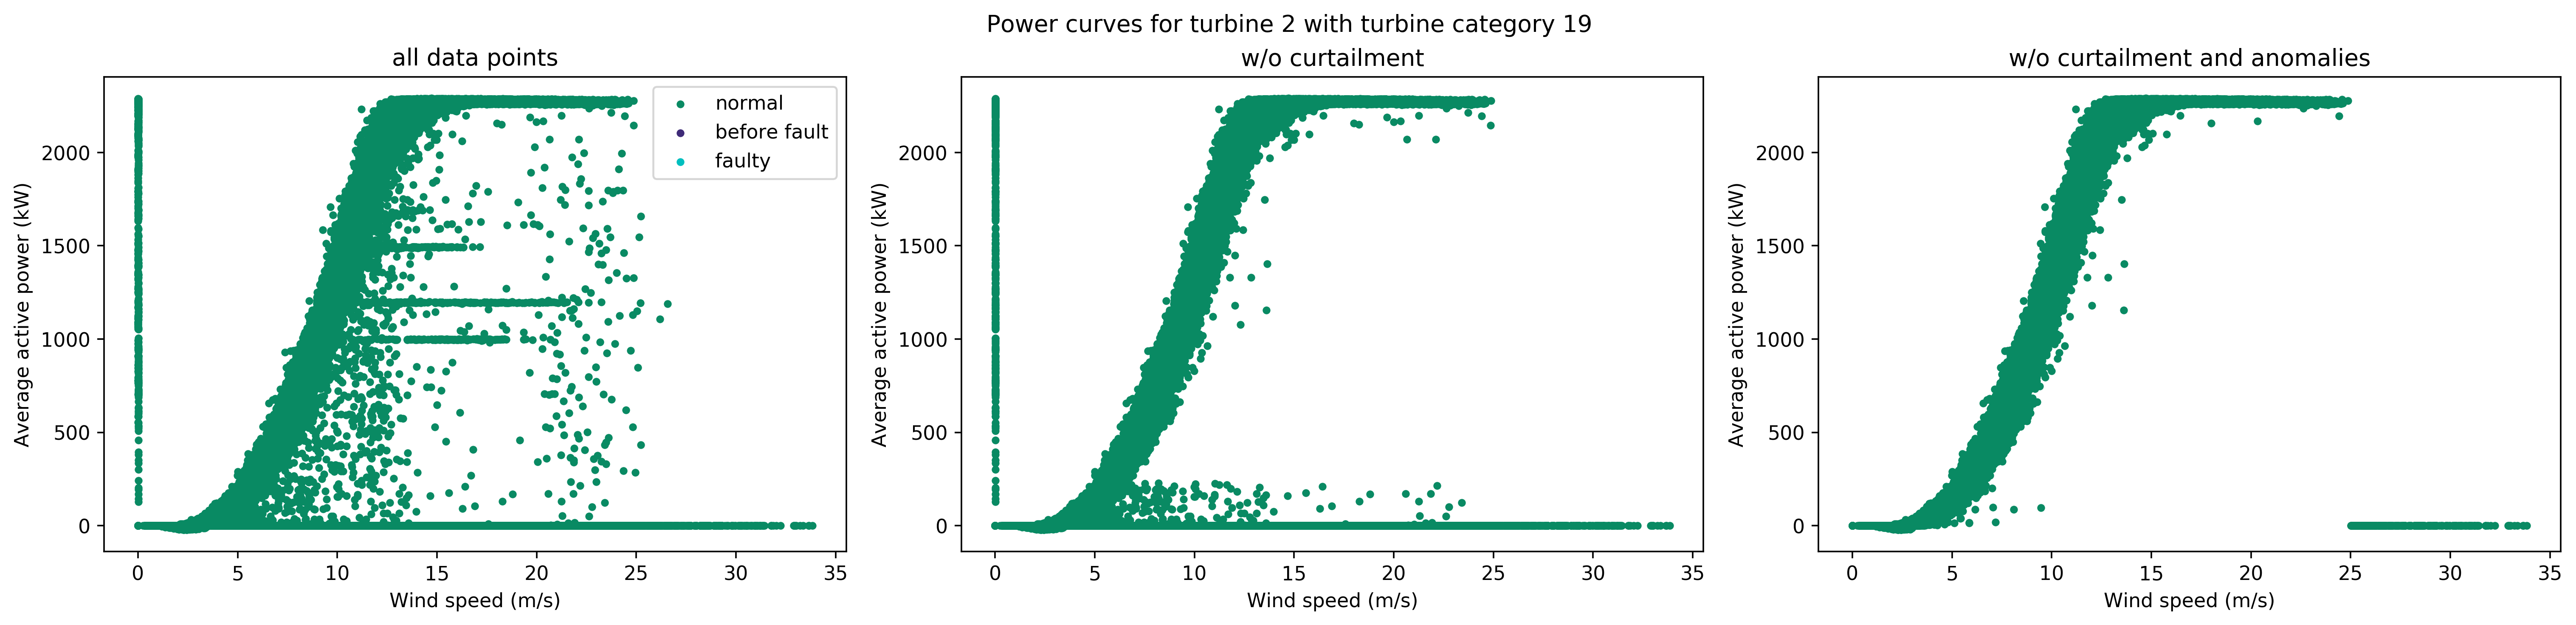

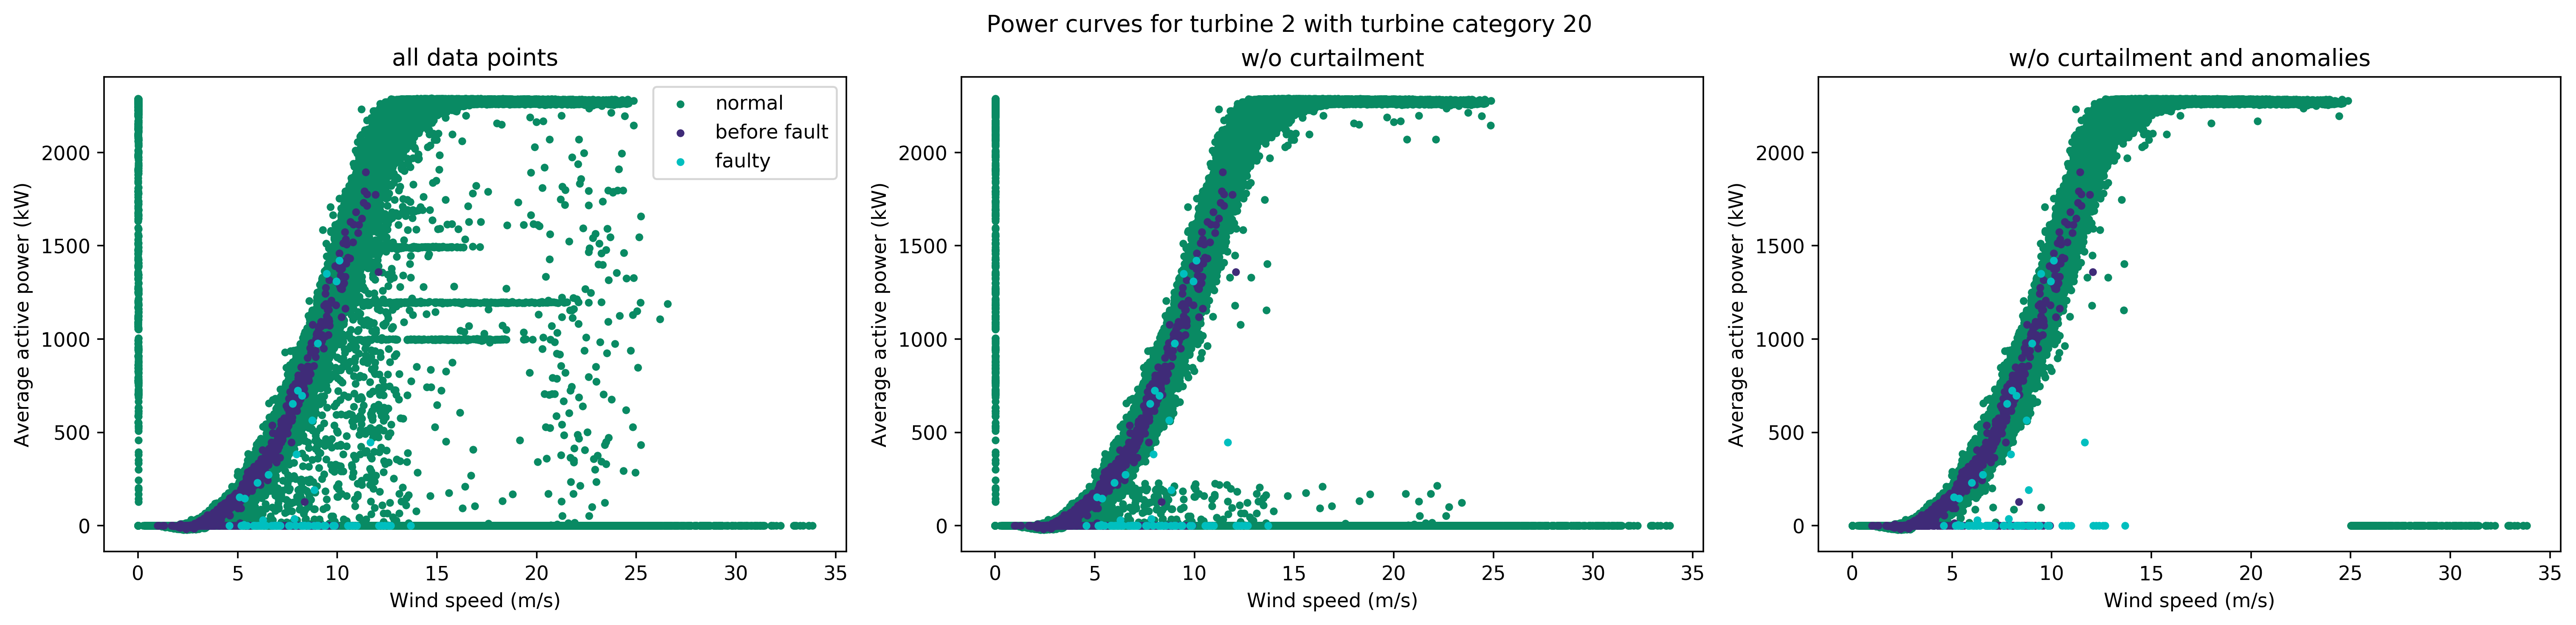

In [1]:
# filter only data for turbine x and plot
for (x, y) in list3:
    df2x = df[(df['turbine_id'] == x)].copy()
    # sort values by timestamp in descending order
    df2x = df2x.sort_values(by='timestamp', ascending=False)

    # copying fault to new column (mins)
    # (fault when turbine category id is y)
    def f(c):
        if c['TurbineCategory_id'] == y:
            return 0
        else:
            return 1
    df2x['mins'] = df2x.apply(f, axis=1)
    # reset index
    df2x.reset_index(drop=True, inplace=True)
    # assigning value to first cell if it's not 0
    if df2x.loc[0, 'mins'] == 0:
        df2x.set_value(0, 'mins', 0)
    else:
        df2x.set_value(0, 'mins', 999999999)

    # using previous value's row to evaluate time
    for i, e in enumerate(df2x['mins']):
        if e == 1:
            df2x.at[i, 'mins'] = df2x.at[i-1, 'mins'] + 10

    # sort in ascending order
    df2x = df2x.sort_values(by='timestamp')
    # reset index
    df2x.reset_index(drop=True, inplace=True)

    # convert to hours and round to nearest hour
    df2x['hours'] = df2x['mins'].astype(np.int64)
    df2x['hours'] = df2x['hours']/60
    df2x['hours'] = round(df2x['hours']).astype(np.int64)

    # > 48 hours - label as normal (9999)
    def f1(c):
        if c['hours'] > 48:
            return 9999
        else:
            return c['hours']
    df2x['hours'] = df2x.apply(f1, axis=1)

    # filter out curtailment - curtailed when turbine is pitching
    # outside 0 deg <= normal <= 3.5 deg
    def f2(c):
        if 0 <= c['pitch'] <= 3.5 or c['hours'] != 9999 or (
                (c['pitch'] > 3.5 or c['pitch'] < 0) and (
                    c['ap_av'] <= (.1 * df2x['ap_av'].max()) or
                    c['ap_av'] >= (.9 * df2x['ap_av'].max()))):
            return 'normal'
        else:
            return 'curtailed'
    df2x['curtailment'] = df2x.apply(f2, axis=1)

    # filter unusual readings, i.e., for normal operation, power <= 0 in
    # operating wind speeds, power > 100 before cut-in, runtime < 600
    def f3(c):
        if c['hours'] == 9999 and ((
                    3 < c['ws_av'] < 25 and (
                        c['ap_av'] <= 0 or
                        c['runtime'] < 600 or
                        c['EnvironmentalCategory_id'] > 1 or
                        c['GridCategory_id'] > 1 or
                        c['InfrastructureCategory_id'] > 1 or
                        c['AvailabilityCategory_id'] == 2 or
                        12 <= c['TurbineCategory_id'] <= 15 or
                        21 <= c['TurbineCategory_id'] <= 22)) or
                (c['ws_av'] < 3 and c['ap_av'] > 100)):
            return 'unusual'
        else:
            return 'normal'
    df2x['unusual'] = df2x.apply(f3, axis=1)

    # filter data for plots
    # normal w/ curtailment (all data)
    df3 = df2x[df2x.hours == 9999]
    # before fault
    df4 = df2x[df2x.hours != 9999]
    df4 = df4[df4.hours != 0]
    # fault
    df5 = df2x[df2x.hours == 0]
    # normal w/o curtailment
    df6 = df3[df3.curtailment == 'normal']
    # normal w/o curtailment and unusual readings
    df7 = df6[df6.unusual == 'normal']

    # get x and y coordinates
    # normal w/ curtailment
    x1 = df3['ws_av']
    y1 = df3['ap_av']
    # before fault
    x2 = df4['ws_av']
    y2 = df4['ap_av']
    # faulty
    x3 = df5['ws_av']
    y3 = df5['ap_av']
    # normal w/o curtailment
    x4 = df6['ws_av']
    y4 = df6['ap_av']
    # normal w/o curtailment and unusual readings
    x5 = df7['ws_av']
    y5 = df7['ap_av']

    fig = plt.figure(figsize=(18.5, 4.5), dpi=1500)

    ax1 = fig.add_subplot(131)
    ax1.scatter(x1, y1, c='#098A63', label='normal', marker='.')
    ax1.scatter(x2, y2, c='#3F2B78', label='before fault', marker='.')
    ax1.scatter(x3, y3, c='c', label='faulty', marker='.')
    ax1.legend()
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Average active power (kW)')
    plt.title('all data points')

    ax2 = fig.add_subplot(132)
    ax2.scatter(x4, y4, c='#098A63', marker='.')
    ax2.scatter(x2, y2, c='#3F2B78', marker='.')
    ax2.scatter(x3, y3, c='c', marker='.')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Average active power (kW)')
    plt.title('w/o curtailment')

    ax3 = fig.add_subplot(133)
    ax3.scatter(x5, y5, c='#098A63', marker='.')
    ax3.scatter(x2, y2, c='#3F2B78', marker='.')
    ax3.scatter(x3, y3, c='c', marker='.')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Average active power (kW)')
    plt.title('w/o curtailment and anomalies')

    fig.suptitle(
        'Power curves for turbine %s' % x + ' with turbine category %s' % y)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()